# Imports

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import shap
from sklearn.svm import SVR

os.environ["KERAS_BACKEND"] = "jax"

from keras import Sequential
from keras.src.layers import Input, LSTM, Dense
from shap.plots import colors
from sklearn.ensemble import RandomForestRegressor as RandomForest
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from xgboost import XGBRegressor

SEED = 100

def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)
    np.random.seed(rnd_seed)
    tf.random.set_seed(rnd_seed)


reset_seed()



# Load Datasets



In [27]:
df = pd.read_csv('./dataset/elect_merged_selected.csv', sep=";", decimal=",", header=0)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df = df[df["date"] <= '2023-12-31']
df.set_index("date", inplace=True)

df_climatic = pd.read_csv('dataset/climatic.csv', sep=";", decimal=",", header=0)
df_climatic["date"] = pd.to_datetime(df_climatic["date"], format="%d/%m/%Y")
df_climatic.set_index("date", inplace=True)

df = df.astype("float32")

x = df.drop("consumption", axis=1)
y = df["consumption"]


# Best Params

In [28]:
best = {}
for model in ["LSTM", "RF", "SVR", "XGB"]:
    df_aux = pd.DataFrame()
    for optimizer in ["GA", "PSO"]:
        for seed, name in [("1000", "A"), ("2000", "B"), ("3000", "C")]:
            df_aux = pd.concat([df_aux,
                                pd.read_csv(f'params/{optimizer}-{model} ITERS SEED {seed}.csv', sep=";",
                                            decimal=",",
                                            header=0)], axis=0)
    df_aux = df_aux.sort_values(by=["Fitness"])
    df_aux[df_aux.isnull()] = None
    best[f"{model}"] = df_aux[:1].iloc[0].to_dict()

# Prediction
## Model Instantiation

In [29]:

#LSTM
tf.keras.backend.clear_session()
lstm = Sequential([
    Input((x.shape[1], 1)),
    LSTM(best["LSTM"]["Units"],
         activation=best["LSTM"]["Activation"],
         use_bias=best["LSTM"]["Bias"],
         seed=SEED),
    Dense(1),
])
lstm.compile(loss='mse')

#RF
rf = RandomForest(random_state=SEED,
                  n_estimators=int(best["RF"]["N_estimators"]),
                  max_depth=int(best["RF"]["Max_depth"]),
                  min_samples_split=int(best["RF"]["Min_samples_split"]),
                  min_samples_leaf=int(best["RF"]["Min_samples_leaf"]))

#SVR
svr = SVR(C=best["SVR"]["C"],
          epsilon=best["SVR"]["Epsilon"],
          kernel=best["SVR"]["Kernel"])

#XGB
updater = "coord_descent" if best["XGB"]["Booster"] == "gblinear" else None
xgb = XGBRegressor(random_state=SEED,
                   n_estimators=int(best["XGB"]["N_estimators"]),
                   max_depth=int(best["XGB"]["Max_depth"]),
                   booster=best["XGB"]["Booster"],
                   reg_lambda=best["XGB"]["Lambda"],
                   reg_alpha=best["XGB"]["Alpha"],
                   updater=updater)



## Train Split

In [34]:

N_SPLITS = 5
H = 12
i = 1

preds_lstm = []
preds_rf = []
preds_svr = []
preds_xgb = []

scores_lstm = []
scores_rf = []
scores_svr = []
scores_xgb = []

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=H, shuffle=False)
for i_train, i_test in TimeSeriesSplit(n_splits=N_SPLITS, test_size=1).split(x_train, y_train):
    reset_seed()
    kx_train, kx_test = x_train.iloc[i_train].to_numpy(), x_train.iloc[i_test].to_numpy()
    ky_train, ky_test = y_train.iloc[i_train].to_numpy(), y_train.iloc[i_test].to_numpy()

    lstm.fit(kx_train, ky_train, shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
             batch_size=best["LSTM"]["Batch Size"])
    rf.fit(kx_train, ky_train)
    svr.fit(kx_train, ky_train)
    xgb.fit(kx_train, ky_train)

    pred_lstm = int(lstm.predict(kx_test)[0][0])
    pred_rf = int(rf.predict(kx_test)[0])
    pred_svr = int(svr.predict(kx_test)[0])
    pred_xgb = int(xgb.predict(kx_test)[0])

    preds_lstm.append(pred_lstm)
    preds_rf.append(pred_rf)
    preds_svr.append(pred_svr)
    preds_xgb.append(pred_xgb)

    scores_lstm.append(mean_absolute_error(ky_test, [pred_lstm]))
    scores_rf.append(mean_absolute_error(ky_test, [pred_rf]))
    scores_svr.append(mean_absolute_error(ky_test, [pred_svr]))
    scores_xgb.append(mean_absolute_error(ky_test, [pred_xgb]))

    i = i + 1

lstm.fit(x_train.to_numpy(), y_train.to_numpy(), shuffle=False, verbose=False, epochs=best["LSTM"]["Epochs"],
         batch_size=best["LSTM"]["Batch Size"])
rf.fit(x_train.to_numpy(), y_train.to_numpy())
svr.fit(x_train.to_numpy(), y_train.to_numpy())
xgb.fit(x_train.to_numpy(), y_train.to_numpy())

df = pd.DataFrame({
    "LSTM": pd.Series(scores_lstm),
    "RF": pd.Series(scores_rf),
    "SVR": pd.Series(scores_svr),
    "XGB": pd.Series(scores_xgb),
})

display(df)

1/1 [==============================] - 0s 60ms/step


LSTM    2004.0
RF      1700.8
SVR      820.0
XGB     1047.4
dtype: float64

## Test Split

1/1 [==============================] - 0s 22ms/step


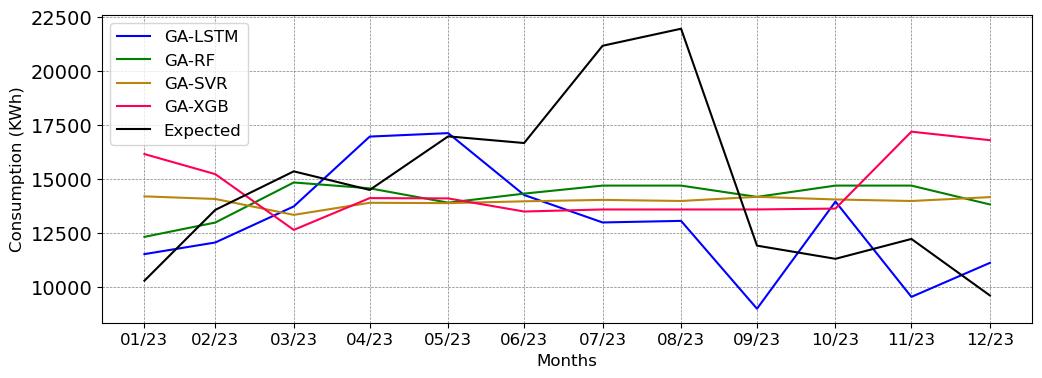

In [31]:

preds_lstm = []
preds_rf = []
preds_svr = []
preds_xgb = []

datasets_lstm = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_rf = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_svr = pd.concat([x_train.copy(), y_train.copy()], axis=1)
datasets_xgb = pd.concat([x_train.copy(), y_train.copy()], axis=1)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_lstm = pd.concat([datasets_lstm, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_lstm["consumption"].shift(lag)
            datasets_lstm[f'LAG_' + '{:02d}'.format(lag)] = datasets_lstm["consumption"].shift(lag)

    pred = int(lstm.predict(sx_test_aux.to_numpy())[0][0])

    sx_test_aux["consumption"] = pred
    preds_lstm.append(pred)
    datasets_lstm.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_rf = pd.concat([datasets_rf, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_rf["consumption"].shift(lag)
            datasets_rf[f'LAG_' + '{:02d}'.format(lag)] = datasets_rf["consumption"].shift(lag)

    pred = int(rf.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_rf.append(pred)
    datasets_rf.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_svr = pd.concat([datasets_svr, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_svr["consumption"].shift(lag)
            datasets_svr[f'LAG_' + '{:02d}'.format(lag)] = datasets_svr["consumption"].shift(lag)

    pred = int(svr.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_svr.append(pred)
    datasets_svr.update(sx_test_aux)

for i_test in range(len(x_test)):
    sx_test = x_test.iloc[[i_test]].astype(float)
    sx_test_aux = sx_test.copy()

    #Get the lags for each model based in the last prediction
    datasets_xgb = pd.concat([datasets_xgb, sx_test_aux], axis=0)
    for lag in range(1, 12 + 1):
        if 'LAG_' + "{:02d}".format(lag) in sx_test.columns:
            sx_test_aux[f'LAG_' + '{:02d}'.format(lag)] = datasets_xgb["consumption"].shift(lag)
            datasets_xgb[f'LAG_' + '{:02d}'.format(lag)] = datasets_xgb["consumption"].shift(lag)

    pred = int(xgb.predict(sx_test_aux.to_numpy())[0])

    sx_test_aux["consumption"] = pred
    preds_xgb.append(pred)
    datasets_xgb.update(sx_test_aux)

plt.figure(figsize=(12, 4))
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue", "green", "darkgoldenrod", colors.red_rgb])

plt.plot(x_test.index, preds_lstm, label="GA-LSTM")
plt.plot(x_test.index, preds_rf, label="GA-RF")
plt.plot(x_test.index, preds_svr, label="GA-SVR")
plt.plot(x_test.index, preds_xgb, label="GA-XGB")
plt.plot(x_test.index, y_test, label="Expected", color="black")

plt.xlabel('Months')
plt.ylabel('Consumption (KWh)')

ax = plt.gca()
ax.set_facecolor('white')
plt.xticks(x_test.index, x_test.index.strftime("%m/%y"))
plt.grid(True, color='grey', linestyle="--", linewidth=0.5)
plt.legend(facecolor='white', )
plt.savefig("results/Forecast Results.png", bbox_inches='tight')
plt.show()


In [32]:
df_measures = pd.DataFrame(index=["MAE", "MAPE"], columns=["LSTM", "RF", "SVR", "XGB"])
df_measures["LSTM"] = pd.Series(
    [mean_absolute_error(y_test, preds_lstm), mean_absolute_percentage_error(y_test, preds_lstm)],
    index=["MAE", "MAPE"])
df_measures["RF"] = pd.Series([mean_absolute_error(y_test, preds_rf), mean_absolute_percentage_error(y_test, preds_rf)],
                              index=["MAE", "MAPE"])
df_measures["SVR"] = pd.Series(
    [mean_absolute_error(y_test, preds_svr), mean_absolute_percentage_error(y_test, preds_svr)], index=["MAE", "MAPE"])
df_measures["XGB"] = pd.Series(
    [mean_absolute_error(y_test, preds_xgb), mean_absolute_percentage_error(y_test, preds_xgb)], index=["MAE", "MAPE"])

df_measures.to_csv(f"results/Measures.csv", sep=";", decimal=",", index=True)
df_measures

,LSTM,RF,SVR,XGB
MAE,3023.500000,2894.583333,3274.583333,4069.000000
MAPE,0.192779,0.197754,0.224212,0.291951


# SHAP Values - Random Forest

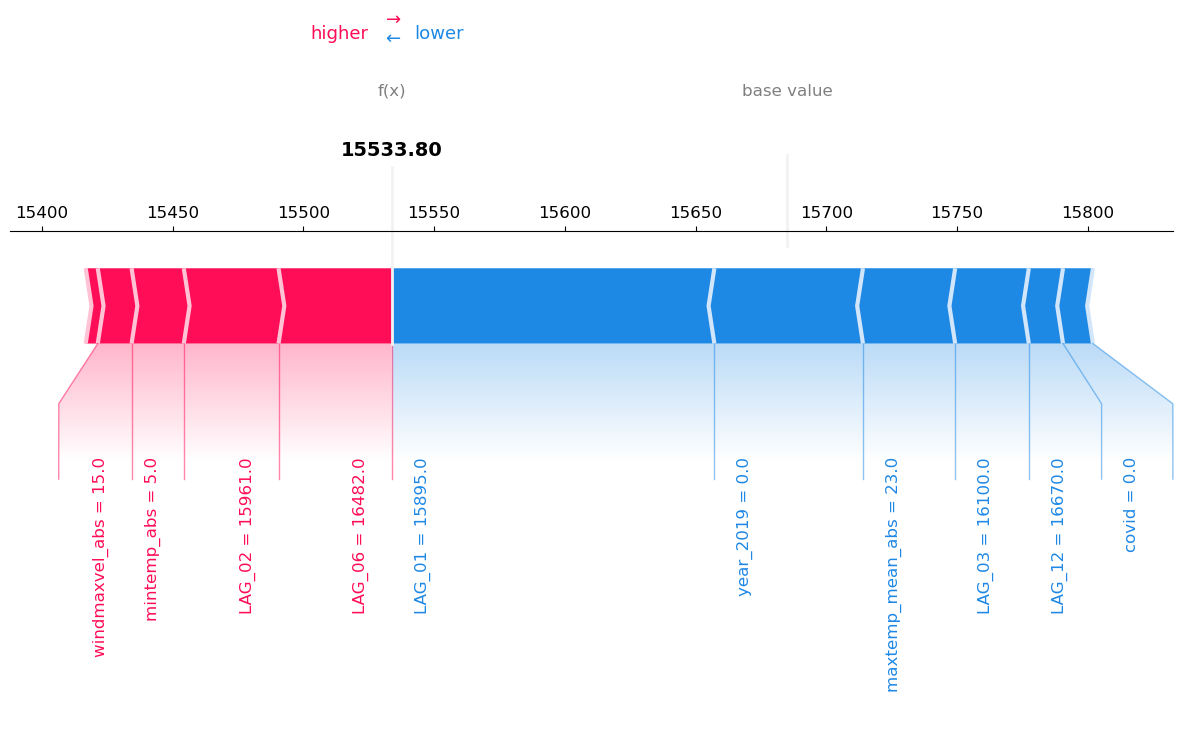

In [33]:
shap.initjs()

explainer_rf = shap.Explainer(rf)
shap_rf = explainer_rf(x_train)

base_values_rf = pd.DataFrame(index=x_train.columns)
values_rf = pd.DataFrame(index=x_train.columns)
data_rf = pd.DataFrame(index=x_train.columns)

for sample in shap_rf:
    base_values_rf = pd.concat([base_values_rf, pd.Series(sample.base_values, index=x_train.columns)], axis=1)
    values_rf = pd.concat([values_rf, pd.Series(sample.values, index=x_train.columns)], axis=1)
    data_rf = pd.concat([data_rf, pd.Series(sample.data, index=x_train.columns)], axis=1)

shap.plots.force(base_value=base_values_rf.mean(axis=1).to_numpy(),
                 shap_values=values_rf.mean(axis=1).to_numpy(),
                 features=data_rf.mean(axis=1).to_numpy().astype(int),
                 feature_names=x_train.columns,
                 matplotlib=True,
                 figsize=(12, 8),
                 text_rotation=90,
                 show=False)

plt.tight_layout()
plt.savefig("results/SHAP FORCE RF.png", bbox_inches='tight')
plt.show()
